In [4]:
# Standard Packages
from torch.utils.data import random_split, DataLoader
import torch
import wandb
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
# Custom Packages
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
import ssapp.data.AntennaDatasetLoaders as AntennaDatasets
from ssapp.Utils import train_test_data_split, FigureSaver
from ssapp.data.Metrics import relRMSE, relRMSE_pytorch
from ssapp.models.HelperFunctions import loadModel
from ssapp.models.NeuralNetworkModels.SimpleFeedForward import FCBenchmark,PDNN
##Settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver(subfolder='Neural Net Direct Prediction')

DEFAULT_CONFIG = {
    "learning_rate": 3e-4,
    "epochs": 310,
    "batch_size": 64,
    'num layers':3,
    'phi_k' : 64,
    's_c' : 1.7,
    'alpha': 0.01,
    'dataset': 'CircularHornDataset1',
    #'dataset': 'PatchAntennaDataset2',
    }

model = PDNN(input_size = 2,
            num_layers=DEFAULT_CONFIG['num layers'],
            phi_k = DEFAULT_CONFIG['phi_k'],
            s_c = DEFAULT_CONFIG['s_c'],
            alpha = DEFAULT_CONFIG['alpha'])

model = loadModel(model,'FeedForwardPatchAntenna/sage-valley-13.pt')
model.eval()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[185, 109, 64]
c:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\models\FeedForwardPatchAntenna\sage-valley-13.pt


RuntimeError: Error(s) in loading state_dict for PDNN:
	size mismatch for regressor.0.weight: copying a param with shape torch.Size([4335, 2]) from checkpoint, the shape in current model is torch.Size([185, 2]).
	size mismatch for regressor.0.bias: copying a param with shape torch.Size([4335]) from checkpoint, the shape in current model is torch.Size([185]).
	size mismatch for regressor.2.weight: copying a param with shape torch.Size([2550, 4335]) from checkpoint, the shape in current model is torch.Size([109, 185]).
	size mismatch for regressor.2.bias: copying a param with shape torch.Size([2550]) from checkpoint, the shape in current model is torch.Size([109]).
	size mismatch for regressor.4.weight: copying a param with shape torch.Size([1500, 2550]) from checkpoint, the shape in current model is torch.Size([64, 109]).
	size mismatch for regressor.4.bias: copying a param with shape torch.Size([1500]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for regressor.6.weight: copying a param with shape torch.Size([4332, 1500]) from checkpoint, the shape in current model is torch.Size([4332, 64]).

In [ ]:
#Verify model performance

AntennaDatasets.set_global_random_seed(42)

train_set = AntennaDatasets.load_serialized_dataset('CircularHornDataset1_Train')
val_dataset =  AntennaDatasets.load_serialized_dataset('CircularHornDataset1_Val')

#train_set = AntennaDatasets.load_serialized_dataset('PatchAntennaDataset2_Train')
#val_dataset =  AntennaDatasets.load_serialized_dataset('PatchAntennaDataset2_Val')

train_dataloader = DataLoader(train_set, batch_size = len(train_set), shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)

train_params, train_fields = next(iter(train_dataloader))
test_params, test_fields = next(iter(test_dataloader))
print(train_params.shape)
train_pred = model(train_params.float())
test_pred = model(test_params.float())

print('Relative RMSE Train',relRMSE_pytorch(train_pred, train_fields).item())
print('Relative RMSE Test',relRMSE_pytorch(test_pred, test_fields).item())


torch.Size([2800, 2])
Relative RMSE Train 0.0018834104241682718
Relative RMSE Test 0.0025320259498341335


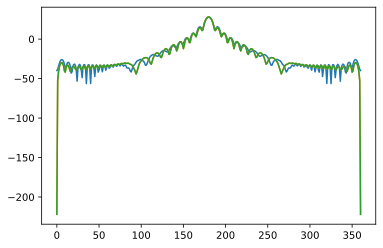

In [3]:
from ssapp.Utils import get_single_dataset_example

mag = lambda a,b: 20*np.log10(np.sqrt(a**2+b**2))
#mag = lambda a,b: (np.sqrt(a**2+b**2))
params, fields = get_single_dataset_example(val_dataset)

plt.figure()
plt.plot(mag(fields[0,:,0,0],fields[0,:,0,1]))

plt.plot(mag(fields[0,:,1,0],fields[0,:,1,1]))
plt.plot(mag(fields[0,:,1,0],fields[0,:,1,1]))

tensor([[1.1383, 0.3528]])


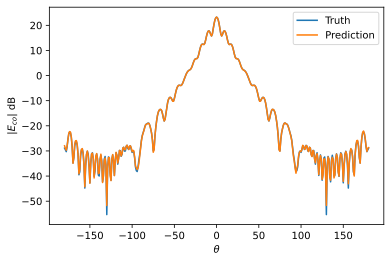

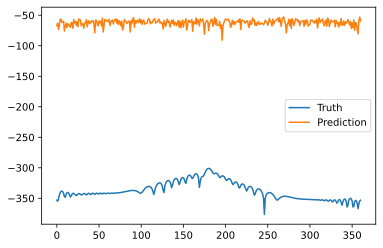

In [ ]:
from ssapp.Utils import get_single_dataset_example

theta = np.linspace(-180,180,361)
print(params)

pred = model(params).detach()

plt.plot(theta,mag(fields[0,:,0,0],fields[0,:,0,1]),label = 'Truth')
plt.plot(theta,mag(pred[0,:,0,0],pred[0,:,0,1]),label = 'Prediction')
plt.ylabel('$|E_{co}|$ dB')
plt.xlabel(r'$\theta$')
plt.legend()


plt.figure()
plt.plot(mag(fields[0,:,0,2],fields[0,:,0,3]),label = 'Truth')
plt.plot(mag(pred[0,:,0,2],pred[0,:,0,3]),label = 'Prediction')
plt.legend()